## KTD

In [67]:
import numpy as np

class KalmanTD:
    """
    Extended Kalman Temporal Differences (KTD) implementation
    to support generalized value function approximation.
    """

    def __init__(self, num_features, tau, gamma, sigma_w, sigma_r, forward_model):
        """
        Initialize the KalmanTD instance.

        Parameters:
        - num_features: Number of features in the parameter vector theta.
        - tau: Process noise parameter (controls the covariance increase).
        - gamma: Discount factor.
        - sigma_w: Initial weight covariance scaling factor.
        - sigma_r: Standard deviation of the reward noise.
        - forward_model: A handle to the value function approximation model
          (non-linear with respect to theta).
        """
        self.num_features = num_features
        self.gamma = gamma
        self.sigma_r = sigma_r
        self.forward_model = forward_model  # Non-linear value function

        # Initialize weights mean (theta estimate) and covariance (Sigma)
        self.weights_mean = np.zeros((num_features, 1))  # Theta estimate
        self.weights_cov = (sigma_w ** 2) * np.identity(num_features)

        # Process noise covariance (Q = tau^2 * I)
        self.process_noise_cov = (tau ** 2) * np.identity(num_features)

    def predict(self):
        """
        Prediction step: Update the covariance with process noise.
        """
        self.weights_cov += self.process_noise_cov

    def update(self, actual_reward, state, next_state):
        """
        Perform the update step of the Extended Kalman Filter.

        Parameters:
        - actual_reward: Observed reward at time t.
        - state: Current state index.
        - next_state: Next state index.
        """
        # Current estimate of theta
        theta = self.weights_mean

        # Compute value function and its derivative at current and next states
        V_s = self.forward_model(theta.item())[state]
        V_s_prime = self.forward_model(theta.item())[next_state]

        # Compute the Jacobians (derivatives) at states s and s'
        grad_V_s = self.compute_jacobian(theta.item(), state)
        grad_V_s_prime = self.compute_jacobian(theta.item(), next_state)

        # Compute the observation model h_t and its Jacobian H_t
        h_t = -V_s + self.gamma * V_s_prime
        H_t = -grad_V_s + self.gamma * grad_V_s_prime  # (num_features x 1)

        # Innovation (prediction error)
        delta = actual_reward - h_t.item()

        # Kalman gain computation
        temp = self.weights_cov @ H_t
        denom = (H_t.T @ temp).item() + (self.sigma_r ** 2)
        kalman_gain = temp / denom  # (num_features x 1)

        # Update weights mean and covariance
        self.weights_mean += kalman_gain * delta
        self.weights_cov -= kalman_gain @ H_t.T @ self.weights_cov

    def compute_jacobian(self, theta, state):
        """
        Compute the derivative of the value function with respect to theta at a given state.

        Parameters:
        - theta: Current parameter value (scalar).
        - state: State index.

        Returns:
        - Jacobian vector (num_features x 1).
        """
        # Numerical approximation of the derivative
        epsilon = 1e-5
        V_plus = self.forward_model(theta + epsilon)
        V_minus = self.forward_model(theta - epsilon)
        derivative = (V_plus[state] - V_minus[state]) / (2 * epsilon)
        return np.array([[derivative.item()]])  # Ensure it's a column vector

    @staticmethod
    def default_kalman_td(num_features, forward_model):
        """
        Create a KalmanTD instance with default parameters.

        Parameters:
        - num_features: Number of features.
        - forward_model: Value function approximation model.

        Returns:
        - Instance of KalmanTD with default settings.
        """
        return KalmanTD(
            num_features=num_features,
            tau=np.sqrt(1e-3),
            gamma=0.98,
            sigma_w=np.sqrt(10),
            sigma_r=np.sqrt(0.1 * 10),
            forward_model=forward_model
        )


## EKI-KTD

In [68]:
from numpy.linalg import svd, solve
import scipy.linalg

def forward_model(H_matrix):
    """
    Creates a forward model function using the matrix H.
    
    Parameters:
    - H_matrix: A numpy array representing the observation matrix.
    
    Returns:
    - A function that takes the parameter ensemble (xi_ensemble) and returns the simulated observations.
    """
    def model(xi_ensemble):
        return H_matrix @ xi_ensemble.T
    
    return model

def enkf_step(xi_train_ensemble, H_func, y, sig_Q, sig_R, is_perturbing_y, using_SVD,iid_perturbating_y=False ):
    """
    Performs a single iteration step of the Ensemble Kalman Filter, with optional SVD optimization.

    Parameters:
    - xi_train_ensemble: Current ensemble of parameters
    - H_func: Function handle for the observation operator
    - y: Observation data
    - sig_Q: Standard deviation of process noise
    - sig_R: Standard deviation of observation noise
    - is_perturbing_y: Boolean flag indicating if observation noise should be added
    - using_SVD: Boolean flag indicating if SVD should be used for optimization

    Returns:
    - xi_train_ensemble: Updated ensemble of parameters after one iteration
    - xi_sample_mean: Mean of the ensemble
    """
    n_en, n_xi = xi_train_ensemble.shape

    # Prediction Step: Adding noise to the ensemble
    noise = np.random.normal(0, sig_Q, (n_en, n_xi))
    xi_train_ensemble += noise

    # Update the sample mean and covariance
    xi_sample_mean = np.mean(xi_train_ensemble, axis=0)
    xi_vec = xi_train_ensemble - xi_sample_mean

    # Simulate the observation using the observation function
    y_sim = H_func(xi_train_ensemble)
    y_sample_mean = np.mean(y_sim, axis=0)
    y_vec = y_sim - y_sample_mean

    if is_perturbing_y:
        if iid_perturbating_y:
            y_obs = y + np.random.normal(0, sig_R, y_sim.shape).T
        else:
            y_obs = y + np.random.normal(0, sig_R, y.shape)
    else:
        y_obs = y

    
    if using_SVD:
        # Compute the covariance matrix Y_p_t and use SVD for optimization
        obs_noise_cov_inv = (1/sig_R)**2 * np.eye(y.shape[0])
        Z_p_t = xi_vec / np.sqrt(n_en - 1)
        Y_p_t = y_vec / np.sqrt(n_en - 1)

        X = Y_p_t @ obs_noise_cov_inv @ Y_p_t.T
        U, S, Vt = svd(X)
        
        P = U 
        Γ = S # Γ is a vector

        tmp = np.dot(Y_p_t, obs_noise_cov_inv @ (y_obs - y_sim.T))
        tmp = np.dot(P.T, tmp)

        tmp *= (1 / (Γ + 1))[:, np.newaxis]
            
        tmp = np.dot(P, tmp)
        update = np.dot(Z_p_t.T, tmp)
    else:
        # Standard Kalman update without SVD
        Cov_yy = np.dot(y_vec.T, y_vec) / (n_en - 1)
        Cov_xiy =  np.dot(xi_vec.T, y_vec) / (n_en - 1)
        S = Cov_yy + sig_R**2 * np.eye(y.shape[0])
        temp = np.linalg.solve(S, y_obs - y_sim.T)
        update = Cov_xiy @ temp
    xi_train_ensemble += 1.01 * update.T
    xi_sample_mean = np.mean(xi_train_ensemble, axis=0)

    return xi_train_ensemble, xi_sample_mean

## Nonlinear approximation of function: Tsitsiklis Chain

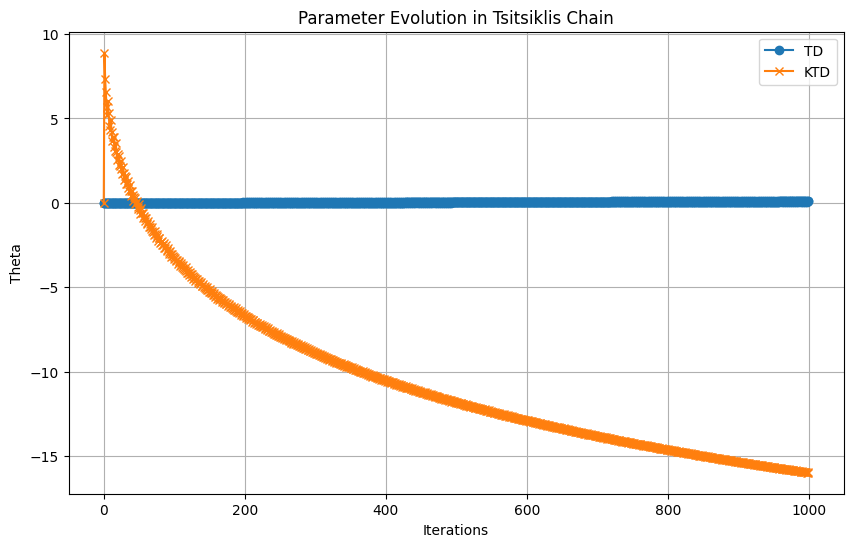

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
# from kalman_td import KalmanTD

# Define parameters for the Tsitsiklis Chain
epsilon = 0.15  # Small constant
gamma = 0.98    # Discount factor

# Initial value function vector V0
V0 = np.array([[10], [-7], [-3]])

# Transition matrix M
M = np.array([
    [1, 0.5, 1.5],
    [1.5, 1, 0.5],
    [0.5, 1.5, 1]
])

I = np.eye(3)  # Identity matrix

# Non-linear value function approximation model
def nonlinear_forward_model(theta):
    """
    Non-linear value function approximation model based on the Tsitsiklis Chain.

    V_hat(theta) = expm((M + epsilon * I) * theta) @ V0

    Parameters:
    - theta: Parameter value (scalar).

    Returns:
    - V_hat: Estimated value function vector.
    """
    return expm((M + epsilon * I) * theta) @ V0

# TD update function
def td_update(theta, alpha, V_hat, state, next_state, gamma):
    """
    Perform TD update for a single transition.

    Parameters:
    - theta: Current parameter value (scalar).
    - alpha: Learning rate.
    - V_hat: Current value function vector at theta.
    - state: Current state index.
    - next_state: Next state index.
    - gamma: Discount factor.

    Returns:
    - Updated theta value.
    """
    td_error = -V_hat[state] + gamma * V_hat[next_state]
    delta = td_error.item()  # Convert to scalar
    theta_new = theta + alpha * delta
    return theta_new

# Simulation parameters
num_iterations = 1000
alpha = 2e-3  # Learning rate for TD

# Initialize TD and KTD parameters
theta_td = 0.0  # Initial theta for TD
theta_td_list = [theta_td]

# Initialize KTD
ktd = KalmanTD.default_kalman_td(num_features=1, forward_model=nonlinear_forward_model)
theta_ktd_list = [ktd.weights_mean[0, 0]]

# State transitions in the Tsitsiklis Chain
transitions = [(0, 1), (1, 2), (2, 0)]

# Run the simulation
for i in range(num_iterations):
    for state, next_state in transitions:
        # TD Update
        V_hat_td = nonlinear_forward_model(theta_td)
        theta_td = td_update(theta_td, alpha, V_hat_td, state, next_state, gamma)
        theta_td_list.append(theta_td)

        # KTD Update 
        actual_reward = 0.0  # Tsitsiklis chain rewards are zero
        ktd.predict()
        ktd.update(actual_reward, state, next_state)
        theta_ktd_list.append(ktd.weights_mean[0, 0])

# Adjust the length of lists for plotting
theta_td_list = theta_td_list[:num_iterations]
theta_ktd_list = theta_ktd_list[:num_iterations]

# Plot the parameter trajectories
plt.figure(figsize=(10, 6))
plt.plot(theta_td_list, label="TD", marker='o')
plt.plot(theta_ktd_list, label="KTD", marker='x')
plt.title("Parameter Evolution in Tsitsiklis Chain")
plt.xlabel("Iterations")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)
plt.show()


## Nonstationary Chain: Boyan Chain

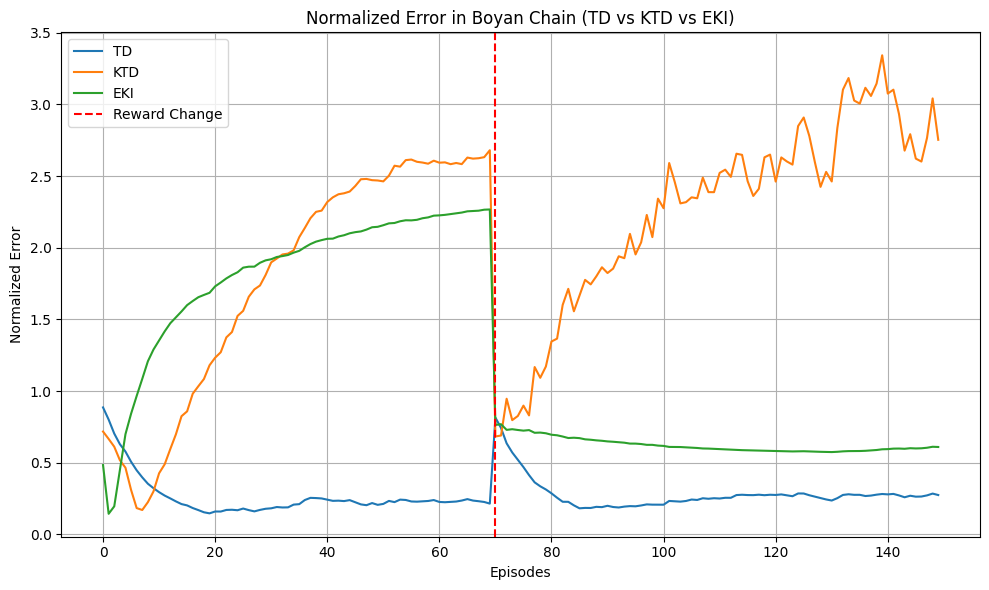

Final Parameters:
TD Theta: [-238.05280641 -191.36767836 -128.74995211  -58.27887377]
KTD Theta: [-416.86768844 -481.36138947 -526.37997827 -587.56427768]
EKI Theta: [-150.21546351 -146.75376561 -143.7498797  -144.99251333]
Optimal Theta: [-240. -160.  -80.    0.]


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, solve

# Boyan Chain Environment Setup
num_states = 13  # s0, s1, ..., s12
terminal_state = 0

base_reward_s1 = -2
base_reward_others = -3
reward_scale_change_episode = 70

def get_reward(state, episode_count):
    scale = 1.0 if episode_count < reward_scale_change_episode else 10.0
    if state == 1:
        return base_reward_s1 * scale
    elif state >= 2:
        return base_reward_others * scale
    else:
        return 0.0  # s0为终止状态，无奖励

def transition(state):
    if state == 0:
        return [(0, 1.0)]
    elif state == 1:
        return [(0, 1.0)]
    else:
        return [(state-1, 0.5), (state-2, 0.5)]

anchors = [0,4,8,12]
anchor_features = {
    0: np.array([0,0,0,1]),
    4: np.array([0,0,1,0]),
    8: np.array([0,1,0,0]),
    12:np.array([1,0,0,0])
}

def get_phi(s):
    if s in anchor_features:
        return anchor_features[s].copy()
    for i in range(len(anchors)-1):
        if anchors[i] < s < anchors[i+1]:
            s_left = anchors[i]
            s_right = anchors[i+1]
            phi_left = anchor_features[s_left]
            phi_right = anchor_features[s_right]
            ratio = (s - s_left) / (s_right - s_left)
            return (1-ratio)*phi_left + ratio*phi_right
    return np.zeros(4)

num_features = 4

theta_star_1 = np.array([-24,-16,-8,0], dtype=float)
theta_star_2 = 10.0 * theta_star_1

def get_optimal_theta(episode_count):
    if episode_count < reward_scale_change_episode:
        return theta_star_1
    else:
        return theta_star_2

def normalized_error(theta, theta_star):
    return np.linalg.norm(theta - theta_star) / np.linalg.norm(theta_star)

def value_function(theta, s):
    phi = get_phi(s)
    return phi @ theta

# TD update
def td_update(theta, alpha, s, s_next, r, gamma):
    v_s = value_function(theta, s)
    v_s_next = value_function(theta, s_next)
    delta = r + gamma * v_s_next - v_s
    return theta + alpha * delta * get_phi(s)


# KTD Implementation
class KTD:
    def __init__(self, num_features, gamma, sigma2=1e-2, eta=1e-3):
        self.num_features = num_features
        self.gamma = gamma
        self.theta_mean = np.zeros(num_features)
        self.P = np.eye(num_features)
        self.sigma2 = sigma2
        self.eta = eta
    
    def predict(self):
        self.P += self.eta * self.P

    def update(self, s, s_next, r):
        # h_theta = V(s) - gamma*V(s')
        v_s = value_function(self.theta_mean, s)
        v_s_next = value_function(self.theta_mean, s_next)
        h_theta = v_s - self.gamma * v_s_next
        delta = r - h_theta
        H = get_phi(s) - self.gamma * get_phi(s_next)  
        H = H.reshape(-1, 1)
        
        PH = self.P @ H
        S = H.T @ PH + self.sigma2
        K = PH / S
        self.theta_mean += (K.flatten() * delta)
        # infaltion of P to be stable
        inflation_factor = 0.999  
        self.P = (self.P - (K @ H.T) * S) * inflation_factor
        # self.P -= (K @ H.T) * S


# EKI Related functions

def forward_model_dynamic(s_snext_list, gamma):

    def model(xi_ensemble):
        n_en = xi_ensemble.shape[0]
        M = len(s_snext_list)
        pred = np.zeros((M, n_en))
        for i, (ss, ssn) in enumerate(s_snext_list):
            for j in range(n_en):
                theta_j = xi_ensemble[j,:]
                # g(theta) = V(s) - gamma V(s')
                g = value_function(theta_j, ss) - gamma * value_function(theta_j, ssn)
                pred[i,j] = g
        return pred.T  
    
    return model


# Testing
num_episodes = 150
alpha = 0.3
gamma = 0.95

# initializing TD and KTD
theta_td = np.zeros(num_features)
theta_ktd = KTD(num_features, gamma=gamma, sigma2=1e-2, eta=1e-3)

td_errors = []
ktd_errors = []

# EKI parameters
n_en = 300
sig_Q = 0.00000
sig_R = 0.015
is_perturbing_y = True
using_SVD = False
M = 10  # update EKI every M steps

m_0 = np.zeros(num_features)
P = 0.2**2 * np.eye(num_features)
xi_train_ensemble = m_0 + np.random.multivariate_normal(np.zeros(num_features), P, size=n_en)
eki_errors = []

for ep in range(num_episodes):
    s = 12
    theta_opt = get_optimal_theta(ep)
    # EKI data cache
    s_snext_list = []
    r_list = []

    while s != 0:
        transitions = transition(s)
        rand_val = np.random.rand()
        cum_prob = 0.0
        for s_next, p in transitions:
            cum_prob += p
            if rand_val <= cum_prob:
                break
        r = get_reward(s, ep)

        # TD
        theta_td = td_update(theta_td, alpha, s, s_next, r, gamma)

        # KTD
        theta_ktd.predict()
        theta_ktd.update(s, s_next, r)

        # EKI data cache
        s_snext_list.append((s, s_next))
        r_list.append(r)
        if len(r_list) == M:
            H_func = forward_model_dynamic(s_snext_list, gamma)
            y_obs = np.array(r_list).reshape(-1,1)
            xi_train_ensemble, xi_sample_mean = enkf_step(
                xi_train_ensemble, H_func, y_obs, sig_Q, sig_R, 
                is_perturbing_y, using_SVD
            )
            s_snext_list.clear()
            r_list.clear()

        s = s_next

    if len(r_list) > 0:
        H_func = forward_model_dynamic(s_snext_list, gamma)
        y_obs = np.array(r_list).reshape(-1,1)
        xi_train_ensemble, xi_sample_mean = enkf_step(
            xi_train_ensemble, H_func, y_obs, sig_Q, sig_R, 
            is_perturbing_y, using_SVD
        )

    # Error
    td_err = normalized_error(theta_td, theta_opt)
    ktd_err = normalized_error(theta_ktd.theta_mean, theta_opt)
    xi_sample_mean = np.mean(xi_train_ensemble, axis=0)
    eki_err = normalized_error(xi_sample_mean, theta_opt)

    td_errors.append(td_err)
    ktd_errors.append(ktd_err)
    eki_errors.append(eki_err)

# Plot
plt.figure(figsize=(10,6))
plt.plot(td_errors, label="TD")
plt.plot(ktd_errors, label="KTD")
plt.plot(eki_errors, label="EKI")
plt.axvline(x=reward_scale_change_episode, color='r', linestyle='--', label='Reward Change')
plt.title("Normalized Error in Boyan Chain (TD vs KTD vs EKI)")
plt.xlabel("Episodes")
plt.ylabel("Normalized Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Final Parameters:")
print("TD Theta:", theta_td)
print("KTD Theta:", theta_ktd.theta_mean)
print("EKI Theta:", xi_sample_mean)
print("Optimal Theta:", theta_opt)


### Averaging 10 trials

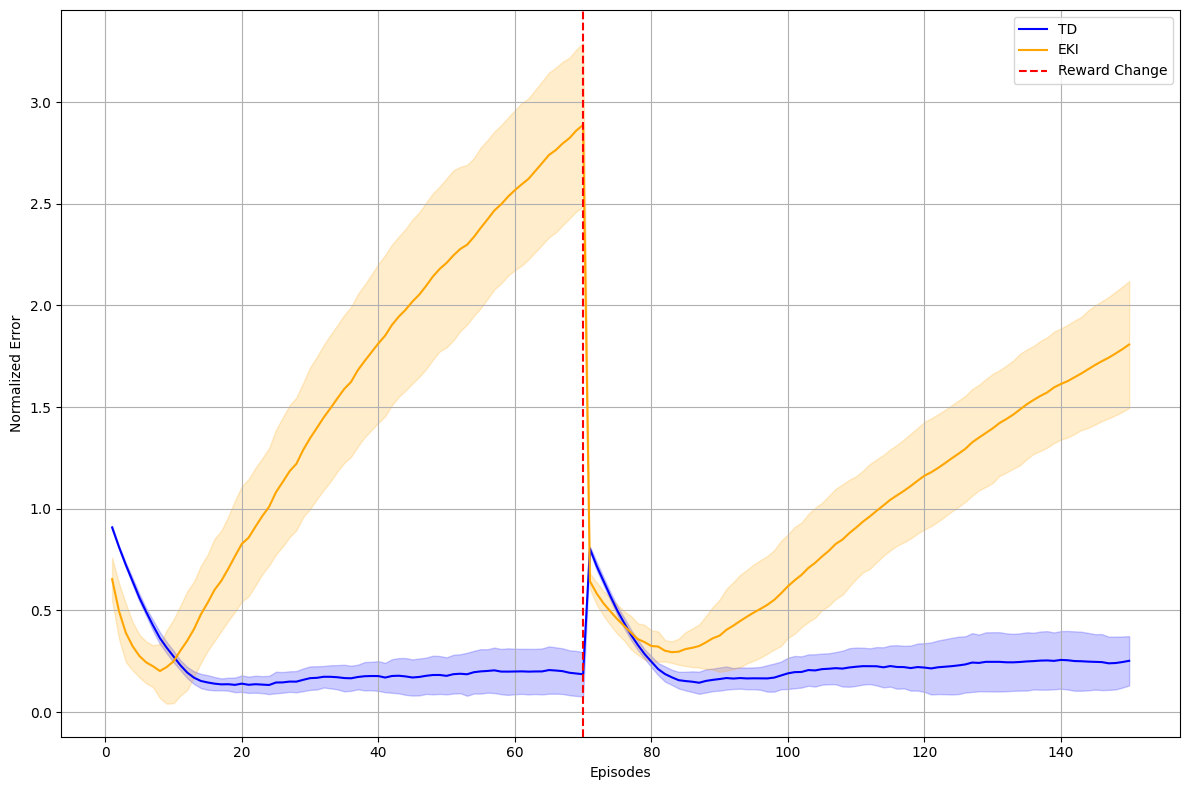

Episode: 150
TD Theta: [-261.11765344 -193.80640397 -111.09371056  -38.78894911]
KalmanTD Theta: [-2.41696568e+16 -3.29743704e+15 -6.87802517e+15 -1.20674698e+17]
EKI Theta: [-463.74634479 -402.00971109 -335.66406436 -272.31291221]
Optimal Theta: [-240. -160.  -80.    0.]


In [328]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, solve

# KalmanTD 
class KalmanTD:
    def __init__(self, num_features, tau, gamma, sigma_w, sigma_r, forward_model):
        self.num_features = num_features
        self.tau = tau
        self.gamma = gamma
        self.sigma_w = sigma_w
        self.sigma_r = sigma_r
        self.forward_model = forward_model
        self.weights_mean = np.zeros(num_features)
        self.weights_cov = np.eye(num_features) * 1.0

    def predict(self):
        # 状态预测（简单的模型）
        self.weights_mean = self.weights_mean  
        self.weights_cov += self.sigma_w**2 * np.eye(self.num_features)

    def update(self, r, s, s_next):
        phi = get_phi(s)
        phi_next = get_phi(s_next)
        target = r + self.gamma * (phi_next @ self.weights_mean)
        y = target - (phi @ self.weights_mean)
        S = phi @ self.weights_cov @ phi + self.sigma_r**2
        K = self.weights_cov @ phi / S
        self.weights_mean += K * y
        self.weights_cov = self.weights_cov - np.outer(K, phi) @ self.weights_cov


# Boyan Chain Environment Setup

num_states = 13
terminal_state = 0

base_reward_s1 = -2
base_reward_others = -3
reward_scale_change_episode = 70

def get_reward(state, episode_count):
    # return reward based on the s and episode_count
    scale = 1.0 if episode_count < reward_scale_change_episode else 10.0
    if state == 1:
        return base_reward_s1 * scale
    elif state >= 2:
        return base_reward_others * scale
    else:
        return 0.0  

def transition(state):
    if state == 0:
        return [(0, 1.0)]
    elif state == 1:
        return [(0, 1.0)]
    else:
        return [(state-1, 0.5), (state-2, 0.5)]

# Feature Representation
anchors = [0,4,8,12]
anchor_features = {
    0: np.array([0,0,0,1]),
    4: np.array([0,0,1,0]),
    8: np.array([0,1,0,0]),
    12:np.array([1,0,0,0])
}

def get_phi(s):
    if s in anchor_features:
        return anchor_features[s].copy()
    for i in range(len(anchors)-1):
        if anchors[i] < s < anchors[i+1]:
            s_left = anchors[i]
            s_right = anchors[i+1]
            phi_left = anchor_features[s_left]
            phi_right = anchor_features[s_right]
            ratio = (s - s_left) / (s_right - s_left)
            return (1-ratio)*phi_left + ratio*phi_right
    return np.zeros(4)

num_features = 4


# Optimal Parameters
theta_star_1 = np.array([-24,-16,-8,0], dtype=float)
theta_star_2 = 10.0 * theta_star_1

def get_optimal_theta(episode_count):
    if episode_count < reward_scale_change_episode:
        return theta_star_1
    else:
        return theta_star_2

def normalized_error(theta, theta_star):
    return np.linalg.norm(theta - theta_star) / np.linalg.norm(theta_star)

def value_function(theta, s):
    phi = get_phi(s)
    return phi @ theta

# TD Update
def td_update(theta, alpha, s, s_next, r, gamma):
    v_s = value_function(theta, s)
    v_s_next = value_function(theta, s_next)
    delta = r + gamma * v_s_next - v_s
    return theta + alpha * delta * get_phi(s)

# EKI Related Functions
def forward_model_dynamic(s_snext_list, gamma):
    """
    Create a forward_model function for EKI.
    """
    def model(xi_ensemble):
        n_en = xi_ensemble.shape[0]
        M = len(s_snext_list)
        pred = np.zeros((M, n_en))
        for i, (ss, ssn) in enumerate(s_snext_list):
            for j in range(n_en):
                theta_j = xi_ensemble[j,:]
                g = value_function(theta_j, ss) - gamma * value_function(theta_j, ssn)
                pred[i,j] = g
        return pred.T  # Returns shape (n_obs, n_en)
    return model


# Run Experiment (TD, KalmanTD, EKI)
def run_experiment():
    num_episodes = 150
    alpha = 0.3  # TD learning rate
    gamma = 0.99

    theta_td_init = np.zeros(num_features)
    
    kalman_td = KalmanTD(
        num_features=num_features,
        tau=np.sqrt(1e-3),
        gamma=gamma,
        sigma_w=np.sqrt(10),
        sigma_r=np.sqrt(0.1 * 10),
        forward_model=None  # 已在KalmanTD内部定义forward_model
    )

    # EKI paras
    n_en = 100  # ensemble size
    sig_Q = 1e-3 
    sig_R = 1e-2  
    is_perturbing_y = True
    using_SVD = False
    M = 1  

    # inialize EKI ensemble
    m_0 = np.zeros(num_features)
    P = 0.15**2 * np.eye(num_features)
    xi_train_ensemble_init = m_0 + np.random.multivariate_normal(np.zeros(num_features), P, size=n_en)
    
    td_errors_run = []
    ktd_errors_run = []
    eki_errors_run = []

    # KalmanTD initialization
    kalman_td_run = KalmanTD(
        num_features=num_features,
        tau=np.sqrt(1e-3),
        gamma=gamma,
        sigma_w=np.sqrt(10),
        sigma_r=np.sqrt(0.1 * 10),
        forward_model=None
    )
    theta_td = theta_td_init.copy()
    kalman_td_run.weights_mean = kalman_td.weights_mean.copy()
    kalman_td_run.weights_cov = kalman_td.weights_cov.copy()
    xi_train_ensemble = xi_train_ensemble_init.copy()
    
    for ep in range(num_episodes):
        s = 12
        theta_opt = get_optimal_theta(ep)
        s_snext_list = []
        r_list = []

        while s != 0:
            transitions_list = transition(s)
            rand_val = np.random.rand()
            cum_prob = 0.0
            for s_next, p in transitions_list:
                cum_prob += p
                if rand_val <= cum_prob:
                    break
            r = get_reward(s, ep)

            # TD Update
            theta_td = td_update(theta_td, alpha, s, s_next, r, gamma)

            # KalmanTD Update
            kalman_td_run.predict()
            kalman_td_run.update(r, s, s_next)

            # EKI data cashe
            s_snext_list.append((s, s_next))
            r_list.append(r)
            if len(r_list) == M:
                H_func = forward_model_dynamic(s_snext_list, gamma)
                y_obs = np.array(r_list).reshape(-1,1)
                xi_train_ensemble, xi_sample_mean = enkf_step(
                    xi_train_ensemble, H_func, y_obs, sig_Q, sig_R, 
                    is_perturbing_y, using_SVD
                )
                s_snext_list.clear()
                r_list.clear()

            s = s_next

        if len(r_list) > 0:
            H_func = forward_model_dynamic(s_snext_list, gamma)
            y_obs = np.array(r_list).reshape(-1,1)
            xi_train_ensemble, xi_sample_mean = enkf_step(
                xi_train_ensemble, H_func, y_obs, sig_Q, sig_R*0.6^ep, 
                is_perturbing_y, using_SVD
            )

        # error
        td_err = normalized_error(theta_td, theta_opt)
        ktd_err = normalized_error(kalman_td_run.weights_mean.flatten(), theta_opt)
        eki_err = normalized_error(xi_sample_mean, theta_opt)

        td_errors_run.append(td_err)
        ktd_errors_run.append(ktd_err)
        eki_errors_run.append(eki_err)

    return td_errors_run, ktd_errors_run, eki_errors_run, theta_td, kalman_td_run.weights_mean, xi_sample_mean


# averaging over multiple trials
num_runs = 10
td_errors_all = []
ktd_errors_all = []
eki_errors_all = []
final_thetas_td = []
final_thetas_ktd = []
final_thetas_eki = []

for run in range(num_runs):
    td_errs, ktd_errs, eki_errs, theta_td_final, theta_ktd_final, theta_eki_final = run_experiment()
    td_errors_all.append(td_errs)
    ktd_errors_all.append(ktd_errs)
    eki_errors_all.append(eki_errs)
    final_thetas_td.append(theta_td_final)
    final_thetas_ktd.append(theta_ktd_final)
    final_thetas_eki.append(theta_eki_final)

td_errors_all = np.array(td_errors_all)  # 形状: (num_runs, num_episodes)
ktd_errors_all = np.array(ktd_errors_all)
eki_errors_all = np.array(eki_errors_all)

td_errors_mean = np.mean(td_errors_all, axis=0)
ktd_errors_mean = np.mean(ktd_errors_all, axis=0)
eki_errors_mean = np.mean(eki_errors_all, axis=0)

td_errors_std = np.std(td_errors_all, axis=0)
ktd_errors_std = np.std(ktd_errors_all, axis=0)
eki_errors_std = np.std(eki_errors_all, axis=0)


plt.figure(figsize=(12,8))
episodes = np.arange(1, 151)

plt.plot(episodes, td_errors_mean, label="TD", color='blue')
plt.fill_between(episodes, td_errors_mean - td_errors_std, td_errors_mean + td_errors_std, color='blue', alpha=0.2)

# plt.plot(episodes, ktd_errors_mean, label="KalmanTD (KTD)", color='green')
# plt.fill_between(episodes, ktd_errors_mean - ktd_errors_std, ktd_errors_mean + ktd_errors_std, color='green', alpha=0.2)

plt.plot(episodes, eki_errors_mean, label="EKI", color='orange')
plt.fill_between(episodes, eki_errors_mean - eki_errors_std, eki_errors_mean + eki_errors_std, color='orange', alpha=0.2)

plt.axvline(x=reward_scale_change_episode, color='red', linestyle='--', label='Reward Change')

# plt.title("Boyan Chain中的归一化误差 (TD vs KalmanTD vs EKI) - 10次运行的平均值")
plt.xlabel("Episodes")
plt.ylabel("Normalized Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Episode: {150}")
print(f"TD Theta: {final_thetas_td[-1]}")
print(f"KalmanTD Theta: {final_thetas_ktd[-1]}")
print(f"EKI Theta: {final_thetas_eki[-1]}")
print(f"Optimal Theta: {get_optimal_theta(150)}")


## Hawk-Dove Game: finding the nash-EQ using SR
However, it seems that implementing this vanilla version of SR only leads to convergence to the maxization of Value function, but not the Nash EQ point.

Training with MAK-SR:
Episode 100: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 200: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 300: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 400: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 500: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 600: Agent 1 Policy = 1, Agent 2 Policy = 0
Episode 700: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 800: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 900: Agent 1 Policy = 0, Agent 2 Policy = 0
Episode 1000: Agent 1 Policy = 0, Agent 2 Policy = 0


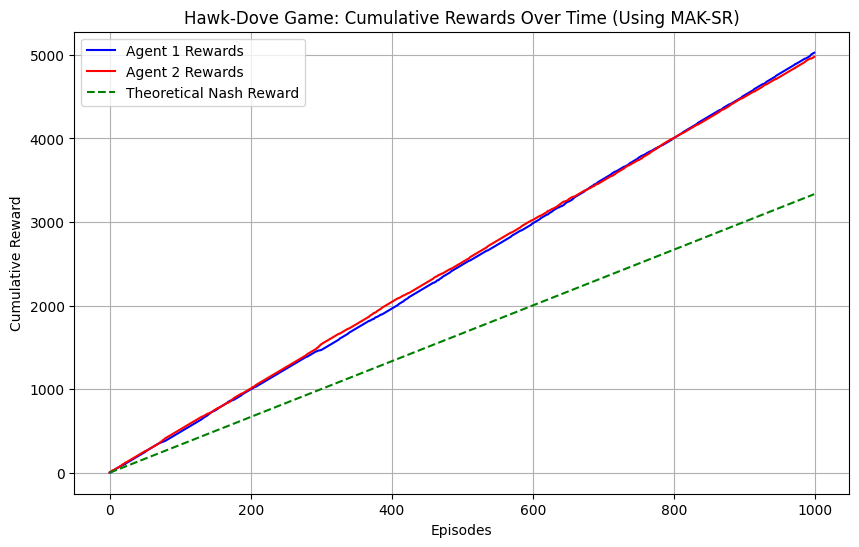


Nash Equilibrium:
Hawk Probability: 0.33, Dove Probability: 0.67

Learned Policies:
Agent 1 Hawk Probability: 0.05
Agent 2 Hawk Probability: 0.04

Comparison to Nash Equilibrium:
Agent 1 Deviation from Nash: 0.28
Agent 2 Deviation from Nash: 0.29
Training with TD:
Episode 100: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 200: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 300: Agent 1 Policy = 1, Agent 2 Policy = 1
Episode 400: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 500: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 600: Agent 1 Policy = 1, Agent 2 Policy = 1
Episode 700: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 800: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 900: Agent 1 Policy = 0, Agent 2 Policy = 1
Episode 1000: Agent 1 Policy = 0, Agent 2 Policy = 1


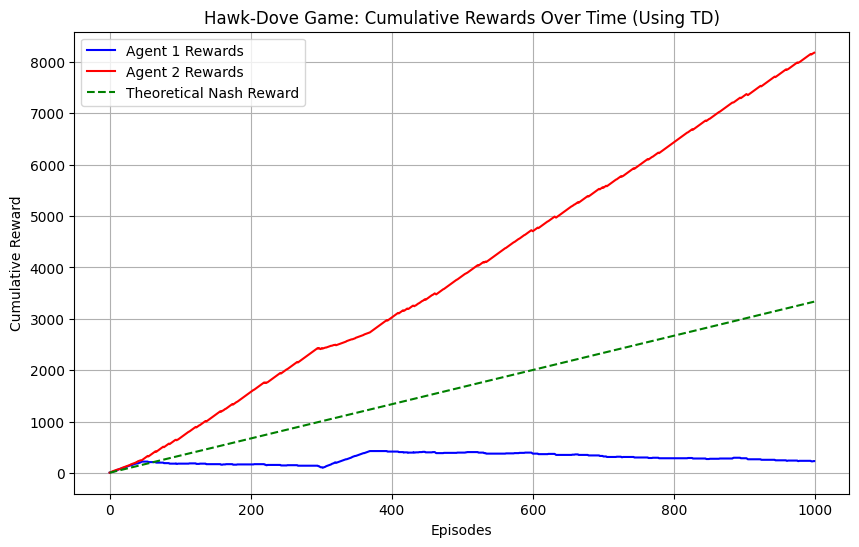


Nash Equilibrium:
Hawk Probability: 0.33, Dove Probability: 0.67

Learned Policies:
Agent 1 Hawk Probability: 0.06
Agent 2 Hawk Probability: 0.86

Comparison to Nash Equilibrium:
Agent 1 Deviation from Nash: 0.27
Agent 2 Deviation from Nash: 0.52


In [75]:
import numpy as np
import random
import matplotlib.pyplot as plt

def hawk_dove_reward(action_i, action_j):
    """
    Compute the reward for agent i and agent j based on actions.
    Static rewards (single state):
    Hawk vs Hawk = -10, Hawk vs Dove = 10/0, Dove vs Dove = 5
    """
    if action_i == 1 and action_j == 1:  # Hawk vs Hawk
        return -10, -10
    elif action_i == 1 and action_j == 0:  # Hawk vs Dove
        return 10, 0
    elif action_i == 0 and action_j == 1:  # Dove vs Hawk
        return 0, 10
    else:  # Dove vs Dove
        return 5, 5

def single_step_nash_equilibrium():
    """
    Compute the Nash equilibrium for the single-step Hawk-Dove game.
    """
    p_hawk = 1 / 3
    p_dove = 2 / 3
    return p_hawk, p_dove

def theoretical_reward_curve(num_episodes):
    """
    Compute the theoretical cumulative reward curve based on Nash equilibrium.
    """
    p_hawk, p_dove = single_step_nash_equilibrium()
    rewards = []
    cumulative_reward = 0
    for _ in range(num_episodes):
        # Expected reward per round
        expected_reward = (
            p_hawk * p_hawk * -10 +  # Hawk vs Hawk
            p_hawk * p_dove * 10 +   # Hawk vs Dove
            p_dove * p_hawk * 0 +    # Dove vs Hawk
            p_dove * p_dove * 5      # Dove vs Dove
        )
        cumulative_reward += expected_reward
        rewards.append(cumulative_reward)
    return rewards

class MARLMDP:
    """
    Multi-Agent Reinforcement Learning framework for a static Hawk-Dove game.
    """
    def __init__(self, action_space, gamma=0.95, use_mak_sr=True):
        self.action_space = action_space
        self.gamma = gamma
        self.use_mak_sr = use_mak_sr
        if use_mak_sr:
            self.agents = [MAKSRAgent(action_space, gamma) for _ in range(2)]
        else:
            self.agents = [TDAgent(action_space, gamma) for _ in range(2)]
        self.rewards = [[], []]  # Rewards for both agents
        self.policy = [[], []]  # Policies tracked over episodes

    def train(self, num_episodes=1000):
        """Train agents in the MARL environment."""
        for episode in range(num_episodes):
            actions = [agent.select_action() for agent in self.agents]
            rewards = hawk_dove_reward(actions[0], actions[1])

            for i, agent in enumerate(self.agents):
                agent.update(actions[i], rewards[i])

            # Track cumulative rewards and policies
            if episode == 0:
                self.rewards[0].append(rewards[0])
                self.rewards[1].append(rewards[1])
            else:
                self.rewards[0].append(self.rewards[0][-1] + rewards[0])
                self.rewards[1].append(self.rewards[1][-1] + rewards[1])
            self.policy[0].append(actions[0])
            self.policy[1].append(actions[1])

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}: Agent 1 Policy = {self.policy[0][-1]}, Agent 2 Policy = {self.policy[1][-1]}")

    def visualize_results(self):
        """Visualize the cumulative rewards over episodes."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rewards[0], label="Agent 1 Rewards", color='blue')
        plt.plot(self.rewards[1], label="Agent 2 Rewards", color='red')

        # Add theoretical Nash equilibrium reward curve
        theoretical_rewards = theoretical_reward_curve(len(self.rewards[0]))
        plt.plot(theoretical_rewards, label="Theoretical Nash Reward", color='green', linestyle='--')

        plt.xlabel("Episodes")
        plt.ylabel("Cumulative Reward")
        plt.title(f"Hawk-Dove Game: Cumulative Rewards Over Time (Using {'MAK-SR' if self.use_mak_sr else 'TD'})")
        plt.legend()
        plt.grid()
        plt.show()

    def compare_policies_to_nash(self):
        """Compare learned policies with Nash equilibrium."""
        nash_p_hawk, nash_p_dove = single_step_nash_equilibrium()

        agent_1_hawk = sum(self.policy[0]) / len(self.policy[0])
        agent_2_hawk = sum(self.policy[1]) / len(self.policy[1])

        print("\nNash Equilibrium:")
        print(f"Hawk Probability: {nash_p_hawk:.2f}, Dove Probability: {nash_p_dove:.2f}")

        print("\nLearned Policies:")
        print(f"Agent 1 Hawk Probability: {agent_1_hawk:.2f}")
        print(f"Agent 2 Hawk Probability: {agent_2_hawk:.2f}")

        diff_1 = abs(agent_1_hawk - nash_p_hawk)
        diff_2 = abs(agent_2_hawk - nash_p_hawk)
        print("\nComparison to Nash Equilibrium:")
        print(f"Agent 1 Deviation from Nash: {diff_1:.2f}")
        print(f"Agent 2 Deviation from Nash: {diff_2:.2f}")

class MAKSRAgent:
    def __init__(self, action_space, gamma=0.95):
        self.action_space = action_space
        self.gamma = gamma
        self.theta = np.random.rand(self.action_space)
        self.sr_matrix = np.zeros(self.action_space)
        self.learning_rate = 0.1
        self.noise = 0.1

    def select_action(self):
        """Select action based on the SR matrix and uncertainty."""
        if random.uniform(0, 1) < self.noise:  # Exploration
            return random.choice(range(self.action_space))
        q_values = self.theta @ self.sr_matrix
        return np.argmax(q_values)

    def update(self, action, reward):
        """Update SR weights and reward weights."""
        # Update SR weights
        td_target = reward
        td_error = td_target - self.sr_matrix[action]
        self.sr_matrix[action] += self.learning_rate * td_error
        # Update reward weights
        error = reward - self.theta[action]
        self.theta[action] += self.learning_rate * error

class TDAgent:
    def __init__(self, action_space, gamma=0.95):
        self.action_space = action_space
        self.gamma = gamma
        self.q_values = np.zeros(self.action_space)
        self.learning_rate = 0.1
        self.noise = 0.1

    def select_action(self):
        """Select action based on Q-values and exploration."""
        if random.uniform(0, 1) < self.noise:  # Exploration
            return random.choice(range(self.action_space))
        return np.argmax(self.q_values)

    def update(self, action, reward):
        """Update Q-values using TD learning."""
        td_target = reward
        td_error = td_target - self.q_values[action]
        self.q_values[action] += self.learning_rate * td_error

# Parameters
NUM_EPISODES = 1000
ACTION_SPACE = 2  # Hawk = 1, Dove = 0

# Run MARL MDP with MAK-SR
print("Training with MAK-SR:")
marl_mdp_sr = MARLMDP(ACTION_SPACE, use_mak_sr=True)
marl_mdp_sr.train(NUM_EPISODES)
marl_mdp_sr.visualize_results()
marl_mdp_sr.compare_policies_to_nash()

# Run MARL MDP with TD
print("Training with TD:")
marl_mdp_td = MARLMDP(ACTION_SPACE, use_mak_sr=False)
marl_mdp_td.train(NUM_EPISODES)
marl_mdp_td.visualize_results()
marl_mdp_td.compare_policies_to_nash()


## SR(Successor Representation)

In [76]:
import numpy as np
import random
import time
from collections import deque

GRID_SIZE = 10
ACTION_SPACE = 4  # Up, Down, Left, Right
TERMINAL_STATE = (4, 4)
SPECIAL_REWARD = {(2, 2): 10}
OBSTACLES = {(1, 1), (3, 3), (5, 5), (6, 4), (6, 6), (7, 7), (2, 6)}

reward_collected = {key: False for key in SPECIAL_REWARD}
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def state_to_index(s):
    return s[0]*GRID_SIZE + s[1]

def move(state, action, stochastic=True):
    # 如果stochastic=False则不执行30%随机动作，用于收敛判定时的评估
    chosen_action = action
    if stochastic and random.uniform(0, 1) < 0.3:  # 30% chance random action
        chosen_action = random.choice(ACTIONS)
    new_state = (state[0] + chosen_action[0], state[1] + chosen_action[1])
    if new_state in OBSTACLES or not (0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE):
        return state
    return new_state

def get_reward(state):
    """Return the reward for a given state with some randomness. Special rewards are one-time only."""
    global reward_collected
    if state == TERMINAL_STATE:
        return 50 + random.uniform(-25, 25)  # Add randomness to terminal state reward
    if state in SPECIAL_REWARD and not reward_collected[state]:
        reward_collected[state] = True  # Mark reward as collected
        return SPECIAL_REWARD[state] + random.uniform(-5, 5)  # Add randomness to special rewards
    if state in OBSTACLES:
        return -10 + random.uniform(-5, 5)  # Add randomness to obstacle penalty
    return -1

def visualize_policy(agent, title="Policy Visualization"):
    directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    grid = np.full((GRID_SIZE, GRID_SIZE), ' ')

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if (i, j) == TERMINAL_STATE:
                grid[i, j] = 'T'
            elif (i, j) in OBSTACLES:
                grid[i, j] = 'X'
            else:
                action = agent.select_action((i, j))
                grid[i, j] = directions[action]

    print(title)
    for row in grid:
        print(' '.join(row))


class TD_Agent:
    def __init__(self, grid_size, action_space, learning_rate=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.lr = learning_rate
        self.q_values = np.zeros((grid_size*grid_size, action_space))

    def select_action(self, state):
        s_idx = state_to_index(state)
        return np.argmax(self.q_values[s_idx])

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        td_target = reward + self.gamma * np.max(self.q_values[s_next])
        td_error = td_target - self.q_values[s, action]
        self.q_values[s, action] += self.lr * td_error

class SR_Agent:
    def __init__(self, grid_size, action_space, alpha=0.1, beta=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha  # SR learning rate
        self.beta = beta    # reward weight learning rate

        self.num_states = grid_size * grid_size
        # SR matrix: (num_states, action_space, num_states)
        self.M = np.zeros((self.num_states, action_space, self.num_states))
        # Reward weights for each state
        self.w = np.zeros(self.num_states)

    def select_action(self, state):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        a_next = self.select_action(next_state)

        phi_s = np.zeros(self.num_states)
        phi_s[s] = 1.0

        # SR update
        td_target_M = phi_s + self.gamma * self.M[s_next, a_next]
        td_error_M = td_target_M - self.M[s, action]
        self.M[s, action] += self.alpha * td_error_M

        # w update
        self.w[s] += self.beta * (reward - self.w[s])



def shortest_path_length():
    """使用 BFS 在无随机动作、无奖励影响时计算从(0,0)到TERMINAL_STATE的最短路径长度。"""
    start = (0,0)
    queue = deque([(start,0)])
    visited = set([start])
    while queue:
        state, dist = queue.popleft()
        if state == TERMINAL_STATE:
            return dist
        for a in ACTIONS:
            new_state = (state[0]+a[0], state[1]+a[1])
            if new_state not in OBSTACLES and 0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE:
                if new_state not in visited:
                    visited.add(new_state)
                    queue.append((new_state, dist+1))
    return None  # 如果找不到路径

def evaluate_policy(agent, max_steps=1000):
    """根据当前策略评估从起点到终点的步数，不执行随机动作干扰。如果无法在max_steps内到达终点，返回一个大值。"""
    state = (0,0)
    for step in range(max_steps):
        if state == TERMINAL_STATE:
            return step
        action = agent.select_action(state)
        state = move(state, ACTIONS[action], stochastic=False)
    return max_steps  # 未到达终点

def train(agent, episodes=200, max_steps=200):
    convergence_episode = -1
    total_samples = 0
    start_time = time.time()

    # 预先计算最短路径
    sp_length = shortest_path_length()
    if sp_length is None:
        print("No path found from start to terminal!")
        return -1, 0, 0.0

    # 要求在连续几次episode中策略的评估路径长度达到最短
    stable_count = 0
    required_stability = 2  # 连续5个episode达到最短路径即认为收敛

    for episode in range(episodes):
        state = (0, 0)
        steps = 0
        # 正常训练
        for _ in range(max_steps):
            total_samples += 1
            action = agent.select_action(state)
            next_state = move(state, ACTIONS[action], stochastic=True)
            reward = get_reward(next_state)
            agent.update(state, action, reward, next_state)
            state = next_state
            if state == TERMINAL_STATE:
                state = (0, 0)

        # 每个episode结束后评估策略
        eval_steps = evaluate_policy(agent, max_steps=1000)
        if eval_steps == sp_length:
            stable_count += 1
            if stable_count >= required_stability and convergence_episode == -1:
                convergence_episode = episode + 1
                break
        else:
            stable_count = 0

    elapsed_time = time.time() - start_time
    if convergence_episode == -1:
        convergence_episode = episodes
    print(f"Training completed in {elapsed_time:.2f} seconds. Convergence at episode {convergence_episode}. Total samples: {total_samples}")
    return convergence_episode, total_samples, elapsed_time

# 训练并对比
print("Training TD Agent...")
td_agent = TD_Agent(GRID_SIZE, ACTION_SPACE, learning_rate=0.1, gamma=0.9)
td_convergence, td_samples, td_time = train(td_agent)

print("Training SR Agent...")
sr_agent = SR_Agent(GRID_SIZE, ACTION_SPACE, alpha=0.1, beta=0.1, gamma=0.9)
sr_convergence, sr_samples, sr_time = train(sr_agent)


# 可视化最终策略
visualize_policy(td_agent, title="TD Agent Policy")
visualize_policy(sr_agent, title="SR Agent Policy")


print(f"TD Agent Convergence Episode: {td_convergence}, Total Samples: {td_samples}, Training Time: {td_time:.2f} seconds")
print(f"SR Agent Convergence Episode: {sr_convergence}, Total Samples: {sr_samples}, Training Time: {sr_time:.2f} seconds")



Training TD Agent...
Training completed in 0.03 seconds. Convergence at episode 15. Total samples: 3000
Training SR Agent...
Training completed in 0.66 seconds. Convergence at episode 200. Total samples: 40000
TD Agent Policy
→ → → ↓ ↓ ← ↑ ↑ → →
↓ X → → ↓ ← → ↓ ↑ ←
← ↓ ↓ → ↓ ← X ↓ → ←
← ↓ ↓ X ↓ ← → → → ←
→ → → ↓ T ← → → → →
← ↑ ↑ ↑ ↑ X ↓ ↓ ↓ ↓
↑ ↓ ↓ ↑ X ↑ X ↑ ↓ ↑
↓ → ↑ ← ↓ ← → X → ←
← ↑ ↑ ↑ ↓ ← ← → ↑ ←
← → ↑ ↓ → ↓ ↑ ↑ ← ↓
SR Agent Policy
↓ → ↓ ← ← → ↓ ← ↓ ↑
↓ X ↓ ← ← → ← ← ↑ →
→ ↓ ↓ ← ← ↑ X ↑ ← ↓
→ ↓ ↓ X ↓ → ↓ ↑ ← ←
→ → ↓ ↑ T ↑ → → ← ←
→ → → → ↑ X ← → ↓ ←
→ ↑ ↑ ↑ X ↓ X → → ↑
→ ↑ ↑ ← ← → ↑ X ← ↑
↓ ↑ ↑ ← ↑ → → ↓ ↓ →
↓ → → ↑ ← ↓ → → ← ↓
TD Agent Convergence Episode: 15, Total Samples: 3000, Training Time: 0.03 seconds
SR Agent Convergence Episode: 200, Total Samples: 40000, Training Time: 0.66 seconds


### Sparser Reward: comparion of sample efficiency (Online)

In [77]:
import numpy as np
import random
import time
from collections import deque

# 将Grid增大为50x50
GRID_SIZE = 20
ACTION_SPACE = 4  # Up, Down, Left, Right
TERMINAL_STATE = (GRID_SIZE-5, GRID_SIZE-5)  # 终点放在接近右下角的位置
OBSTACLES = set()  # 可以根据需要添加障碍，这里暂不添加
# 不设特殊奖励，只有终点奖励
SPECIAL_REWARD = {}

reward_collected = {key: False for key in SPECIAL_REWARD}
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def state_to_index(s):
    return s[0]*GRID_SIZE + s[1]

def move(state, action, stochastic=True):
    # 30%概率随机动作
    chosen_action = action
    if stochastic and random.uniform(0, 1) < 0.3:
        chosen_action = random.choice(ACTIONS)
    new_state = (state[0] + chosen_action[0], state[1] + chosen_action[1])
    if new_state in OBSTACLES or not (0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE):
        return state
    return new_state

def get_reward(state):
    # 只有在终点给予较大正奖励，其余状态给-1的step cost
    if state == TERMINAL_STATE:
        return 100.0  # 高额奖励
    return -1.0

def visualize_policy(agent, title="Policy Visualization"):
    directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    size_to_print = min(50, GRID_SIZE)
    grid = np.full((size_to_print, size_to_print), ' ')

    for i in range(size_to_print):
        for j in range(size_to_print):
            if (i, j) == TERMINAL_STATE and i<size_to_print and j<size_to_print:
                grid[i, j] = 'T'
            elif (i, j) in OBSTACLES and i<size_to_print and j<size_to_print:
                grid[i, j] = 'X'
            else:
                action = agent.select_action((i, j))
                grid[i, j] = directions[action]

    print(title)
    for row in grid:
        print(' '.join(row))

class TD_Agent:
    def __init__(self, grid_size, action_space, learning_rate=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.lr = learning_rate
        self.q_values = np.zeros((grid_size*grid_size, action_space))

    def select_action(self, state):
        s_idx = state_to_index(state)
        return np.argmax(self.q_values[s_idx])

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        td_target = reward + self.gamma * np.max(self.q_values[s_next])
        td_error = td_target - self.q_values[s, action]
        self.q_values[s, action] += self.lr * td_error

class SR_Agent:
    def __init__(self, grid_size, action_space, alpha=0.1, beta=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha  # SR learning rate
        self.beta = beta    # reward weight learning rate

        self.num_states = grid_size * grid_size
        # SR matrix: (num_states, action_space, num_states)
        self.M = np.zeros((self.num_states, action_space, self.num_states))
        # Reward weights for each state
        self.w = np.zeros(self.num_states)

    def select_action(self, state):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        a_next = self.select_action(next_state)

        phi_s = np.zeros(self.num_states)
        phi_s[s] = 1.0

        # SR update
        td_target_M = phi_s + self.gamma * self.M[s_next, a_next]
        td_error_M = td_target_M - self.M[s, action]
        self.M[s, action] += self.alpha * td_error_M

        # w update
        self.w[s] += self.beta * (reward - self.w[s])

def shortest_path_length():
    """即使不一定有用，因为有随机动作，但仍可计算一个最优路径长度参考值(在无随机动作和无阻碍前提下)。"""
    start = (0,0)
    queue = deque([(start,0)])
    visited = set([start])
    while queue:
        state, dist = queue.popleft()
        if state == TERMINAL_STATE:
            return dist
        for a in ACTIONS:
            new_state = (state[0]+a[0], state[1]+a[1])
            if new_state not in OBSTACLES and 0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE:
                if new_state not in visited:
                    visited.add(new_state)
                    queue.append((new_state, dist+1))
    return None

def evaluate_policy(agent, max_steps=5000):
    """评估当前策略在无随机动作情况下所需步数。若无法在max_steps到达终点，则返回max_steps。"""
    state = (0,0)
    for step in range(max_steps):
        if state == TERMINAL_STATE:
            return step
        action = agent.select_action(state)
        state = move(state, ACTIONS[action], stochastic=False)
    return max_steps

def train(agent, episodes=2000, max_steps=200):
    convergence_episode = -1
    total_samples = 0
    start_time = time.time()

    sp_length = shortest_path_length() # 仅做参考，不要求必须匹配此长度
    stable_count = 0
    required_stability = 5

    for episode in range(episodes):
        state = (0, 0)
        for _ in range(max_steps):
            total_samples += 1
            action = agent.select_action(state)
            next_state = move(state, ACTIONS[action], stochastic=True)
            reward = get_reward(next_state)
            agent.update(state, action, reward, next_state)
            state = next_state
            if state == TERMINAL_STATE:
                state = (0, 0)

        # 评估策略能否成功到达终点（无随机动作）
        eval_steps = evaluate_policy(agent, max_steps=5000)
        if eval_steps < 5000:
            stable_count += 1
            if stable_count >= required_stability and convergence_episode == -1:
                convergence_episode = episode + 1
                break
        else:
            stable_count = 0

    elapsed_time = time.time() - start_time
    if convergence_episode == -1:
        convergence_episode = episodes
    print(f"Training completed in {elapsed_time:.2f} seconds. Convergence at episode {convergence_episode}. Total samples: {total_samples}")
    return convergence_episode, total_samples, elapsed_time

# Training and comparison
print("Training TD Agent...")
td_agent = TD_Agent(GRID_SIZE, ACTION_SPACE, learning_rate=0.1, gamma=0.9)
td_convergence, td_samples, td_time = train(td_agent)

print("Training SR Agent...")
sr_agent = SR_Agent(GRID_SIZE, ACTION_SPACE, alpha=0.1, beta=0.1, gamma=0.9)
sr_convergence, sr_samples, sr_time = train(sr_agent)

visualize_policy(td_agent, title="TD Agent Policy (Partial View)")
visualize_policy(sr_agent, title="SR Agent Policy (Partial View)")


print(f"TD Agent Convergence Episode: {td_convergence}, Total Samples: {td_samples}, Training Time: {td_time:.2f} s")
print(f"SR Agent Convergence Episode: {sr_convergence}, Total Samples: {sr_samples}, Training Time: {sr_time:.2f} s")



Training TD Agent...
Training completed in 5.19 seconds. Convergence at episode 663. Total samples: 132600
Training SR Agent...
Training completed in 25.10 seconds. Convergence at episode 989. Total samples: 197800
TD Agent Policy (Partial View)
→ → → → ↓ → ↓ ↓ ↓ → ↓ → → ↓ ↓ ← ↑ ↑ ↑ ↑
↓ ↓ → ↓ → → → ↓ → → ↓ → → ↓ ↑ → ↑ → ↑ →
← ↓ ↓ ↓ → ↓ → ↓ → ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ← ↑ →
↓ ↓ → → → → → ↓ → → ↓ ↓ → ↓ ← → ↓ ↓ ← ←
↓ ↓ ↓ ↓ → → → → ↓ ↓ ↓ ↓ → ↓ ↓ ↓ → ← ← →
→ ↓ ↓ ↓ → ↓ → → → ↓ → → → ↓ ← ← → ↓ ← →
↓ → ↓ ↓ → ↓ ↓ → → → ↓ ↓ ↓ ↓ ↓ ← → ↓ → ↓
↓ ↓ → → ↓ → ↓ → → ↓ → ↓ → ↓ ↓ ← ← ↓ → ↓
↓ ↓ ↓ → → ↓ ↓ → → → → → ↓ ↓ ← ↓ ↑ ↓ ↓ ↑
→ ↓ → → → ↓ ↓ ↓ ↓ ↓ ↓ → → ↓ ← ← ↓ → ← ↓
↓ ↓ ↓ → → → → ↓ ↓ ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ← ← ↓
↓ → → ↓ ↓ → → ↓ ↓ → ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ↓ →
↓ → → → → → → → → ↓ ↓ → → ↓ ↓ ↓ ↓ ← ← ←
↓ → → → → → → → → → → → → ↓ ← ↓ ← ← ← →
↓ ↑ → → ↑ ↑ ↑ ← → → → → → → → ↓ ↓ ↑ → →
↑ ↓ ← ↓ ↓ ↑ ↑ → → ↑ → ↑ → → → T ← ← ↑ ↑
↑ ← ← ↑ ↑ ↑ ↓ ← ← ← ↑ ↑ ↑ → → ↑ ← ← ← ↓
↑ → ↓ ↑ ↓ → ↓ → → ← ↑ → → → → ↑ ← ↑ ← →
↓ ↓ ↓ ↓ → ↓ ↓ ↑ → ↑ ↑ ↑ → ↑ ↑ ← ↓ 

### Space Exploration(Online): whether stuck on the local maximum (outside the cage)

In [79]:
import numpy as np
import random
import time
from collections import deque

# 大网格，远程终点
GRID_SIZE = 15
ACTION_SPACE = 4
TERMINAL_STATE = (GRID_SIZE-1, GRID_SIZE-1)  # 终点在右下角
OBSTACLES = set()  # 无额外障碍
SPECIAL_REWARD = {}
reward_collected = {key: False for key in SPECIAL_REWARD}
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def state_to_index(s):
    return s[0]*GRID_SIZE + s[1]

# 定义陷阱区：例如在(10,10)到(14,14)的区域形成一个5x5方块
# 边缘是刺区：奖励=-20
# 内部是平静区：奖励=0
TRAP_EDGE = {(10, y) for y in range(10,15)} | {(14, y) for y in range(10,15)} | \
             {(x, 10) for x in range(10,15)} | {(x, 14) for x in range(10,15)}
TRAP_INNER = {(x, y) for x in range(11,14) for y in range(11,14)}

def move(state, action, stochastic=True):
    chosen_action = action
    if stochastic and random.uniform(0, 1) < 0.3:
        chosen_action = random.choice(ACTIONS)
    new_state = (state[0] + chosen_action[0], state[1] + chosen_action[1])
    if new_state in OBSTACLES or not (0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE):
        return state
    return new_state

def get_reward(state):
    if state == TERMINAL_STATE:
        return 10000.0
    if state in TRAP_EDGE:
        return -20.0
    if state in TRAP_INNER:
        return 1.0
    return -1.0

def visualize_policy(agent, title="Policy Visualization"):
    directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    size_to_print = min(20, GRID_SIZE)
    grid = np.full((size_to_print, size_to_print), ' ')

    for i in range(size_to_print):
        for j in range(size_to_print):
            if (i, j) == TERMINAL_STATE and i<size_to_print and j<size_to_print:
                grid[i, j] = 'T'
            elif (i,j) in TRAP_EDGE and i<size_to_print and j<size_to_print:
                grid[i,j] = 'E'  # Edge with spikes
            elif (i,j) in TRAP_INNER and i<size_to_print and j<size_to_print:
                grid[i,j] = '.'
            else:
                action = agent.select_action((i, j))
                grid[i, j] = directions[action]

    print(title)
    for row in grid:
        print(' '.join(row))

class TD_Agent:
    def __init__(self, grid_size, action_space, learning_rate=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.lr = learning_rate
        self.q_values = np.zeros((grid_size*grid_size, action_space))

    def select_action(self, state):
        s_idx = state_to_index(state)
        return np.argmax(self.q_values[s_idx])

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        td_target = reward + self.gamma * np.max(self.q_values[s_next])
        td_error = td_target - self.q_values[s, action]
        self.q_values[s, action] += self.lr * td_error

    def get_value(self, state=(0,0)):
        s = state_to_index(state)
        return np.max(self.q_values[s])

class SR_Agent:
    def __init__(self, grid_size, action_space, alpha=0.1, beta=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha  # SR learning rate
        self.beta = beta    # reward weight learning rate

        self.num_states = grid_size * grid_size
        self.M = np.zeros((self.num_states, action_space, self.num_states))
        self.w = np.zeros(self.num_states)

    def select_action(self, state):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        a_next = self.select_action(next_state)

        phi_s = np.zeros(self.num_states)
        phi_s[s] = 1.0

        td_target_M = phi_s + self.gamma * self.M[s_next, a_next]
        td_error_M = td_target_M - self.M[s, action]
        self.M[s, action] += self.alpha * td_error_M
        self.w[s] += self.beta * (reward - self.w[s])

    def get_value(self, state=(0,0)):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.max(q_values)


def evaluate_policy(agent, max_steps=5000):
    state = (0,0)
    for step in range(max_steps):
        if state == TERMINAL_STATE:
            return step
        action = agent.select_action(state)
        state = move(state, ACTIONS[action], stochastic=False)
    return max_steps

def train(agent, episodes=2000, max_steps=200):
    convergence_episode = -1
    total_samples = 0
    start_time = time.time()

    stable_count = 0
    required_stability = 5

    for episode in range(episodes):
        state = (0, 0)
        for _ in range(max_steps):
            total_samples += 1
            action = agent.select_action(state)
            next_state = move(state, ACTIONS[action], stochastic=True)
            reward = get_reward(next_state)
            agent.update(state, action, reward, next_state)
            state = next_state
            if state == TERMINAL_STATE:
                state = (0, 0)

        eval_steps = evaluate_policy(agent, max_steps=5000)
        if eval_steps < 5000:
            stable_count += 1
            if stable_count >= required_stability and convergence_episode == -1:
                convergence_episode = episode + 1
                break
        else:
            stable_count = 0

    elapsed_time = time.time() - start_time
    if convergence_episode == -1:
        convergence_episode = episodes
    print(f"{agent.__class__.__name__}: Training completed in {elapsed_time:.2f} seconds. Convergence at episode {convergence_episode}. Total samples: {total_samples}")
    return convergence_episode, total_samples, elapsed_time

# 训练并对比三个Agent
td_agent = TD_Agent(GRID_SIZE, ACTION_SPACE, learning_rate=0.1, gamma=0.9)
sr_agent = SR_Agent(GRID_SIZE, ACTION_SPACE, alpha=0.1, beta=0.1, gamma=0.9)

td_convergence, td_samples, td_time = train(td_agent)
sr_convergence, sr_samples, sr_time = train(sr_agent)

# 可视化部分区域策略
visualize_policy(td_agent, title="TD Agent Policy")
visualize_policy(sr_agent, title="SR Agent Policy")

# 打印起始点状态的价值
td_value_start = td_agent.get_value((0,0))
sr_value_start = sr_agent.get_value((0,0))

print(f"TD Agent: V(s0) = {td_value_start:.2f}")
print(f"SR Agent: V(s0) = {sr_value_start:.2f}")


TD_Agent: Training completed in 16.20 seconds. Convergence at episode 2000. Total samples: 400000
SR_Agent: Training completed in 52.50 seconds. Convergence at episode 2000. Total samples: 400000
TD Agent Policy
→ → → ↓ ↓ ← ← ↓ → ↓ ↓ ↓ → → ↓
→ → ↓ → ↓ → ↓ → ↓ ↓ ← ← → ← ←
→ → → → ↓ ↓ → ↑ ↓ ↑ ← ↓ ↓ ↑ →
↓ → → → → → ↓ ↓ ↓ ↓ ↓ ↓ ↓ ← ←
→ → → → → → → → → ↓ → ↓ ↓ ↓ ↓
↓ ↑ ↑ → ↓ ↓ ↓ ↓ ↓ ↓ → ↓ ↓ ↓ ←
→ → → → → → → ↓ → → → ↓ ← ← ↓
→ ↓ ↓ → ↓ ↓ → → → → → ↓ ← ← ←
↓ ↓ ↓ → → → ↓ ↓ → → → ↓ ← ← →
→ ← ↓ ↓ ↓ → ↓ ← ↓ → → ↑ ↑ ↑ ←
↓ → ↓ ↓ → → ↓ ↓ ← ← E E E E E
→ → → → → → ↓ → ↓ ← E . . . E
↓ ↑ ↑ ↑ → ↓ → → → ← E . . . E
→ ↓ → ↑ ← → ↑ ↓ ↑ ← E . . . E
← ↑ ↑ ← → ↑ ↑ ↑ ↑ ↑ E E E E T
SR Agent Policy
↑ ↑ → ↓ ↓ → ↓ ↓ → ↓ ↓ ← ↑ → →
↓ ↓ → → ↓ ↑ → ↓ → ← ↑ → ← ← →
← → ← ↑ ↑ ← ↓ ← ↓ ↓ ← ↑ ↑ ↓ →
← ↓ → → ← ← ← ↓ → ↑ → ← ↓ → ↓
→ ↑ → → ↓ ↓ ↓ ↓ ← → → → ↑ ← ↓
→ ↑ ↑ ← → ↓ ↑ ↑ ← ← → ← ← ↑ →
→ → ← ← ↑ ↓ ← ← ← → ↑ ← ↑ ↓ ↑
↓ → ↓ ↑ ↑ → → → ↑ ↑ ↑ ← ↑ ↑ →
← → ↑ ← ↑ ↓ → → ← ← ← ↑ ↑ ↑ ↑
← ↓ ← → → → ↑ ↑ ← ↑ ← ↑ ↑ ← ↑
↑ ↓ ← → ↑ ← ← ↑ ↑ → E 

### TD/SR Online Learning

In [66]:
import numpy as np
import random
import time
from collections import deque

# 大网格，远程终点
GRID_SIZE = 15
ACTION_SPACE = 4
TERMINAL_STATE = (GRID_SIZE-1, GRID_SIZE-1)  # (14,14)
OBSTACLES = set()
SPECIAL_REWARD = {}
reward_collected = {key: False for key in SPECIAL_REWARD}
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def state_to_index(s):
    return s[0]*GRID_SIZE + s[1]

# 将陷阱区改为围栏形式，围绕终点的几格定义为TRAP_EDGE
# 例如在终点(14,14)的上方和左方各加负奖励围栏，以及对角线(13,13)
TRAP_EDGE = {(13,14), (14,13), (13,13)}  # 带刺区域
TRAP_INNER = set()  # 无内部平静区

def move(state, action, stochastic=True):
    chosen_action = action
    if stochastic and random.uniform(0, 1) < 0.1:
        chosen_action = random.choice(ACTIONS)
    new_state = (state[0] + chosen_action[0], state[1] + chosen_action[1])
    if new_state in OBSTACLES or not (0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE):
        return state
    return new_state

def get_reward(state):
    if state == TERMINAL_STATE:
        return 10000.0
    if state in TRAP_EDGE:
        return -20.0  # 围栏区域强力负奖励
    if state in TRAP_INNER:
        return 1.0
    return -1.0

def visualize_policy(agent, title="Policy Visualization"):
    directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    size_to_print = min(20, GRID_SIZE)
    grid = np.full((size_to_print, size_to_print), ' ')

    for i in range(size_to_print):
        for j in range(size_to_print):
            if (i, j) == TERMINAL_STATE and i<size_to_print and j<size_to_print:
                grid[i, j] = 'T'
            elif (i,j) in TRAP_EDGE and i<size_to_print and j<size_to_print:
                grid[i,j] = 'E'  # 围栏区域
            elif (i,j) in TRAP_INNER and i<size_to_print and j<size_to_print:
                grid[i,j] = '.'
            else:
                action = agent.select_action((i, j))
                grid[i, j] = directions[action]

    print(title)
    for row in grid:
        print(' '.join(row))

class TD_Agent:
    def __init__(self, grid_size, action_space, learning_rate=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.lr = learning_rate
        self.q_values = np.zeros((grid_size*grid_size, action_space))

    def select_action(self, state):
        s_idx = state_to_index(state)
        return np.argmax(self.q_values[s_idx])

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        td_target = reward + self.gamma * np.max(self.q_values[s_next])
        td_error = td_target - self.q_values[s, action]
        self.q_values[s, action] += self.lr * td_error

    def get_value(self, state=(0,0)):
        s = state_to_index(state)
        return np.max(self.q_values[s])


class SR_Agent:
    def __init__(self, grid_size, action_space, alpha=0.1, beta=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha  # SR学习率
        self.beta = beta    # 奖励权重学习率

        self.num_states = grid_size * grid_size
        self.M = np.zeros((self.num_states, action_space, self.num_states))
        self.w = np.zeros(self.num_states)

    def select_action(self, state):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        a_next = self.select_action(next_state)

        phi_s = np.zeros(self.num_states)
        phi_s[s] = 1.0

        td_target_M = phi_s + self.gamma * self.M[s_next, a_next]
        td_error_M = td_target_M - self.M[s, action]
        self.M[s, action] += self.alpha * td_error_M
        self.w[s] += self.beta * (reward - self.w[s])

    def get_value(self, state=(0,0)):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.max(q_values)


def evaluate_policy(agent, max_steps=5000):
    state = (0,0)
    for step in range(max_steps):
        if state == TERMINAL_STATE:
            return step
        action = agent.select_action(state)
        state = move(state, ACTIONS[action], stochastic=False)
    return max_steps

def train(agent, episodes=2000, max_steps=200):
    convergence_episode = -1
    total_samples = 0
    start_time = time.time()

    stable_count = 0
    required_stability = 5

    for episode in range(episodes):
        state = (0, 0)
        for _ in range(max_steps):
            total_samples += 1
            action = agent.select_action(state)
            next_state = move(state, ACTIONS[action], stochastic=True)
            reward = get_reward(next_state)
            agent.update(state, action, reward, next_state)
            state = next_state
            if state == TERMINAL_STATE:
                state = (0, 0)

        eval_steps = evaluate_policy(agent, max_steps=5000)
        if eval_steps < 5000:
            stable_count += 1
            if stable_count >= required_stability and convergence_episode == -1:
                convergence_episode = episode + 1
                break
        else:
            stable_count = 0

    elapsed_time = time.time() - start_time
    if convergence_episode == -1:
        convergence_episode = episodes
    print(f"{agent.__class__.__name__}: Training completed in {elapsed_time:.2f} seconds. Convergence at episode {convergence_episode}. Total samples: {total_samples}")
    return convergence_episode, total_samples, elapsed_time

# 对比两个Agent
td_agent = TD_Agent(GRID_SIZE, ACTION_SPACE, learning_rate=0.1, gamma=0.9)
sr_agent = SR_Agent(GRID_SIZE, ACTION_SPACE, alpha=0.1, beta=0.1, gamma=0.9)

td_convergence, td_samples, td_time = train(td_agent)
sr_convergence, sr_samples, sr_time = train(sr_agent)

visualize_policy(td_agent, title="TD Agent Policy (Partial View)")
visualize_policy(sr_agent, title="SR Agent Policy (Partial View)")

td_value_start = td_agent.get_value((0,0))
sr_value_start = sr_agent.get_value((0,0))

print(f"TD Agent: V(s0) = {td_value_start:.2f}")
print(f"SR Agent: V(s0) = {sr_value_start:.2f}")


TD_Agent: Training completed in 16.07 seconds. Convergence at episode 2000. Total samples: 400000
SR_Agent: Training completed in 52.24 seconds. Convergence at episode 2000. Total samples: 400000
TD Agent Policy (Partial View)
↓ → → ↓ ↑ ↓ ↓ → ↓ ↑ → ↑ ↑ ↑ ←
↓ ↓ → ↓ ↓ → ↓ ← → ↓ ← → ↓ ↑ ↑
→ → ↓ ↓ ↓ → ↓ ↓ → ↓ ← ↓ ↓ ↑ →
↑ → → → → → ↓ ← → ↓ → → ↓ ← ←
→ ↓ ↓ ↓ → → ↓ → → ↓ ↓ → ↓ ← ←
→ ↓ → ↓ → → ↓ ↓ → ↓ ↓ → ↓ ← ↓
↓ ↓ ↓ ↓ ↓ → ↓ → → → ↓ → ↓ ↓ →
↓ ↓ ← ↓ ↓ ↓ ↓ ↓ ↓ → ↓ ↓ ↓ ↓ ↓
→ → → → → → → ↓ ↓ → ↓ → ↓ ↓ ←
↑ → → ↓ ↓ → ↓ → ↓ ↓ ↓ → ↓ ↓ ←
↓ → → → → → → → → → ↓ ↓ ↓ ↓ ←
↓ ↓ ↓ ← ↑ ↑ ↑ ↓ ↑ → → ↓ ↓ ↓ ↓
← → ↓ → → ↓ ← ↓ ↑ ↓ → → → ← ←
← ↓ ↑ ← ← ↓ → → → → → ↑ ↑ E E
↓ ↓ → ← ← ↑ ↑ → ↑ ↓ ↑ ↑ ↑ E T
SR Agent Policy (Partial View)
→ ← ↓ ↑ ↓ → → → ↓ ↑ ← ↑ ↑ ↓ →
← ← → ↑ ↓ ↑ → ↑ → ← → ← ↓ ↓ →
↓ ↑ ↑ ↓ → → → ← ↓ ← ↓ ↑ ↑ ← ↓
↑ ← → ↓ → ↑ → ↓ ↑ ↑ → ↑ ← → ↓
→ ↑ ↑ ↑ ↑ → ↑ ↑ → ↑ ↓ → ↓ ← →
↑ → ← ↓ ↑ ← ↓ ↑ ↑ ← ↑ ↓ → → ←
← ← ↑ ↓ ← ↓ ↑ → ↑ → ↑ ↑ ↑ → ←
→ → ↓ ↑ ← ↓ ↑ ← ← ↓ → ↓ ↓ ← →
← ↓ ↑ → ← ↑ → ↓ ↑ → ← ↑ ← ← ←
← ← ↓ ↑ ↓ ↑ ↓ → ← ↓ ↑ 

### TD/SR Offline Learning

In [69]:
import numpy as np
import random
import time
from collections import deque

# 定义环境参数
GRID_SIZE = 15
ACTION_SPACE = 4
TERMINAL_STATE = (GRID_SIZE-1, GRID_SIZE-1)
OBSTACLES = set()
SPECIAL_REWARD = {}
reward_collected = {key: False for key in SPECIAL_REWARD}
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def state_to_index(s):
    return s[0]*GRID_SIZE + s[1]

# 围栏区域，终点被几格负奖励围住
TRAP_EDGE = {(13,14), (14,13), (13,13)}
TRAP_INNER = set()  # 无内部平静区

def move(state, action):
    new_state = (state[0] + action[0], state[1] + action[1])
    if new_state in OBSTACLES or not (0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE):
        return state
    return new_state

def get_reward(state):
    if state == TERMINAL_STATE:
        return 10000.0
    if state in TRAP_EDGE:
        return -20.0
    if state in TRAP_INNER:
        return 1.0
    return -1.0

def visualize_policy(agent, title="Policy Visualization"):
    directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    size_to_print = min(20, GRID_SIZE)
    grid = np.full((size_to_print, size_to_print), ' ')

    for i in range(size_to_print):
        for j in range(size_to_print):
            if (i, j) == TERMINAL_STATE:
                grid[i, j] = 'T'
            elif (i,j) in TRAP_EDGE:
                grid[i,j] = 'E'
            elif (i,j) in TRAP_INNER:
                grid[i,j] = '.'
            else:
                action = agent.select_action((i, j))
                grid[i, j] = directions[action]

    print(title)
    for row in grid:
        print(' '.join(row))

class TD_Agent:
    def __init__(self, grid_size, action_space, learning_rate=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.lr = learning_rate
        self.q_values = np.zeros((grid_size*grid_size, action_space))

    def select_action(self, state):
        s_idx = state_to_index(state)
        return np.argmax(self.q_values[s_idx])

    def update(self, state, action_idx, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)
        td_target = reward + self.gamma * np.max(self.q_values[s_next])
        td_error = td_target - self.q_values[s, action_idx]
        self.q_values[s, action_idx] += self.lr * td_error

    def get_value(self, state=(0,0)):
        s = state_to_index(state)
        return np.max(self.q_values[s])

class SR_Agent:
    def __init__(self, grid_size, action_space, alpha=0.1, beta=0.1, gamma=0.9):
        self.grid_size = grid_size
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta

        self.num_states = grid_size * grid_size
        self.M = np.zeros((self.num_states, action_space, self.num_states))
        self.w = np.zeros(self.num_states)

    def select_action(self, state):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.argmax(q_values)

    def update(self, state, action_idx, reward, next_state):
        s = state_to_index(state)
        s_next = state_to_index(next_state)

        # 为更新M，需要先选出下一状态的贪心动作，但在离线模式下我们不改变数据，只依赖已有数据
        # 不过SR更新依赖下一动作选择，在此简化为选择当前SR估计下的最佳动作
        a_next = self.select_action(next_state)

        phi_s = np.zeros(self.num_states)
        phi_s[s] = 1.0

        td_target_M = phi_s + self.gamma * self.M[s_next, a_next]
        td_error_M = td_target_M - self.M[s, action_idx]
        self.M[s, action_idx] += self.alpha * td_error_M
        self.w[s] += self.beta * (reward - self.w[s])

    def get_value(self, state=(0,0)):
        s = state_to_index(state)
        q_values = [self.M[s,a].dot(self.w) for a in range(self.action_space)]
        return np.max(q_values)

def evaluate_policy(agent, max_steps=5000):
    state = (0,0)
    for step in range(max_steps):
        if state == TERMINAL_STATE:
            return step
        action = agent.select_action(state)
        state = move(state, ACTIONS[action])
    return max_steps

def generate_data(num_episodes=200, max_steps=1000):
    # 使用1/4等概率随机策略来生成数据
    data = []
    for ep in range(num_episodes):
        state = (0,0)
        for _ in range(max_steps):
            # 随机选动作（均匀）
            action_idx = np.random.randint(0, ACTION_SPACE)
            action = ACTIONS[action_idx]
            next_state = move(state, action)
            reward = get_reward(next_state)
            data.append((state, action_idx, reward, next_state))
            if next_state == TERMINAL_STATE:
                break
            state = next_state
    return data

def train_offline(agent, data, epochs=10):
    # 离线训练：对同一批数据多次迭代更新
    start_time = time.time()
    for epoch in range(epochs):
        random.shuffle(data)
        for (s, a_idx, r, s_next) in data:
            agent.update(s, a_idx, r, s_next)
    elapsed_time = time.time() - start_time
    print(f"{agent.__class__.__name__} Offline Training completed in {elapsed_time:.2f} seconds.")

# 数据生成（离线数据）
data = generate_data(num_episodes=200, max_steps=200)

# 创建并离线训练两个Agent
td_agent = TD_Agent(GRID_SIZE, ACTION_SPACE, learning_rate=0.1, gamma=0.9)
sr_agent = SR_Agent(GRID_SIZE, ACTION_SPACE, alpha=0.1, beta=0.1, gamma=0.9)

train_offline(td_agent, data, epochs=50)
train_offline(sr_agent, data, epochs=50)

# 训练完成后评估策略
td_eval_steps = evaluate_policy(td_agent)
sr_eval_steps = evaluate_policy(sr_agent)


visualize_policy(td_agent, title="TD Agent Policy (Offline Learned)")
visualize_policy(sr_agent, title="SR Agent Policy (Offline Learned)")

td_value_start = td_agent.get_value((0,0))
sr_value_start = sr_agent.get_value((0,0))

print(f"TD Agent: V(s0) = {td_value_start:.2f}")
print(f"SR Agent: V(s0) = {sr_value_start:.2f}")


TD_Agent Offline Training completed in 6.07 seconds.
SR_Agent Offline Training completed in 17.81 seconds.
TD Agent Policy (Offline Learned)
↓ ↓ ↓ ↓ ↓ ↓ → ↓ → ↓ ↓ ↓ ↓ ↓ ↓
→ ↓ ↓ → → ↓ ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ↓
↓ → ↓ → ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓
→ → → → ↓ → ↓ → ↓ ↓ ↓ ↓ ↓ ↓ ↓
→ → → → ↓ ↓ → ↓ → → ↓ ↓ ↓ ↓ ↓
→ → → → → ↓ → → → ↓ → ↓ ↓ ↓ ↓
→ → → → → ↓ → ↓ ↓ → ↓ ↓ ↓ ↓ ↓
→ → → → → → ↓ ↓ → → ↓ ↓ ↓ ↓ ↓
→ → → → → → → → → → ↓ → → → ↓
→ → → → ↓ → → → ↓ → → ↓ → → ↓
→ → → → → ↓ ↓ ↓ → ↓ ↓ ↓ → ↓ ↓
→ → → → → → → → → → → → → → ↓
→ → → → → → → → → → → → → → ↓
↓ → ↓ ↓ ↓ ↓ ↓ → ↓ ↓ → → ↓ E E
→ → → → → → → → → → → → → E T
SR Agent Policy (Offline Learned)
↓ → ↓ ↓ ↓ ↓ → ↓ → ↓ ↓ ↓ → ↓ ↓
→ → ↓ ↓ ↓ ↓ ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ↓
↓ → ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓
→ → → → ↓ ↓ ↓ → ↓ ↓ ↓ ↓ ↓ ↓ ↓
→ → → → → → ↓ ↓ → → → ↓ ↓ ↓ ↓
→ → → → → → → ↓ ↓ ↓ → ↓ → ↓ ↓
→ → → → → → → → → → ↓ ↓ ↓ ↓ ↓
→ → → → → → → → → → → → ↓ ↓ ↓
→ → → → → → → → → → → → → → ↓
→ → → → → → → → → → → → → → ↓
→ → → → → → → → → → → → → → ↓
→ → → → → → → → → → → → → → ↓
→ → → → → → → →